In [1]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine

from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [2]:
!jt -t onedork

In [3]:
df = engine.getData('BTC-PERP')
df['time'] = pd.to_datetime(df['time'], unit='ms')
df = df[::-1]
df

,time,open,high,low,close,volume
1499,2021-10-19 22:31:00,64060.0,64090.0,64050.0,64075.0,280952.2440
1498,2021-10-19 22:30:00,64019.0,64060.0,63988.0,64060.0,233112.0035
1497,2021-10-19 22:29:00,64019.0,64039.0,63985.0,64019.0,399948.9213
1496,2021-10-19 22:28:00,64074.0,64080.0,64001.0,64019.0,455659.3919
1495,2021-10-19 22:27:00,64108.0,64109.0,64062.0,64074.0,244942.7711
...,...,...,...,...,...,...
4,2021-10-18 21:36:00,61706.0,61706.0,61687.0,61693.0,145646.1913
3,2021-10-18 21:35:00,61704.0,61713.0,61700.0,61706.0,304854.6547
2,2021-10-18 21:34:00,61710.0,61711.0,61700.0,61704.0,37555.9096
1,2021-10-18 21:33:00,61720.0,61734.0,61700.0,61710.0,694517.2068


In [4]:
df = Algo.fullstate(df,df)
df

,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign
1478,2021-10-19 22:10:00,64164.0,64229.0,64156.0,64212.0,194739.2542,64187.222222,64132.142857,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1477,2021-10-19 22:09:00,64152.0,64172.0,64106.0,64164.0,216537.4174,64191.444444,64138.666667,1.0,-0.000748,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1476,2021-10-19 22:08:00,64098.0,64160.0,64098.0,64152.0,211154.5895,64186.222222,64143.619048,1.0,-0.000187,-0.000748,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1475,2021-10-19 22:07:00,64171.0,64172.0,64098.0,64098.0,157281.7810,64179.333333,64149.952381,1.0,-0.000842,-0.000187,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1474,2021-10-19 22:06:00,64149.0,64197.0,64149.0,64171.0,224633.7070,64165.000000,64153.714286,1.0,0.001138,-0.000842,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-10-18 21:36:00,61706.0,61706.0,61687.0,61693.0,145646.1913,61803.888889,61791.857143,1.0,0.000081,-0.000276,0.0,61803.888889,0.998206,1.0,0.0,0.000081,-1.0
3,2021-10-18 21:35:00,61704.0,61713.0,61700.0,61706.0,304854.6547,61785.666667,61788.285714,-1.0,0.000211,-0.000081,-2.0,61785.666667,0.998711,1.0,0.0,0.000211,-1.0
2,2021-10-18 21:34:00,61710.0,61711.0,61700.0,61704.0,37555.9096,61778.555556,61788.619048,-1.0,-0.000032,-0.000211,0.0,61778.555556,0.998793,1.0,0.0,-0.000032,-1.0
1,2021-10-18 21:33:00,61720.0,61734.0,61700.0,61710.0,694517.2068,61768.555556,61786.714286,-1.0,0.000097,0.000032,0.0,61768.555556,0.999052,1.0,0.0,0.000097,-1.0


In [5]:
df['just_date'] = df['time'].dt.date
df['just_date']

1478    2021-10-19
1477    2021-10-19
1476    2021-10-19
1475    2021-10-19
1474    2021-10-19
           ...    
4       2021-10-18
3       2021-10-18
2       2021-10-18
1       2021-10-18
0       2021-10-18
Name: just_date, Length: 1477, dtype: object

In [6]:
#column for negative and positive
dfR=df.dropna()
dfR['sign'] = np.where(dfR['range_returns'] < 0, 'neg','pos')
#consecutive groups
dfR['series'] = dfR['sign'].ne(dfR['sign'].shift()).cumsum()
#removed groups with length more like 2
df1 = dfR[dfR['series'].map(dfR['series'].value_counts()).gt(2)]
#tested if order `pos-neg` of groups, if not removed groups
m1 = df1['sign'].eq('pos') & df1['sign'].shift(-1).eq('neg')
m2 = df1['sign'].eq('neg') & df1['sign'].shift().eq('pos')
groupsR = df1.loc[m1 | m2, 'series']
df1 = df1[df1['series'].isin(groupsR)].copy()
df1['pairs'] = (df1['sign'].ne(df1['sign'].shift()) & df1['sign'].eq('pos')).cumsum()
dfT=df.dropna()
dfT['sign'] = np.where(dfT['trend_returns'] < 0, 'neg','pos')
#consecutive groups
dfT['series'] = dfT['sign'].ne(dfT['sign'].shift()).cumsum()
#removed groups with length more like 2
df2 = dfT[dfT['series'].map(dfT['series'].value_counts()).gt(2)]
#tested if order `pos-neg` of groups, if not removed groups
m3 = df2['sign'].eq('pos') & df2['sign'].shift(-1).eq('neg')
m4 = df2['sign'].eq('neg') & df2['sign'].shift().eq('pos')
groupsT = df2.loc[m3 | m4, 'series']
df2 = df2[df2['series'].isin(groupsT)].copy()
df2['pairs'] = (df2['sign'].ne(df2['sign'].shift()) & df2['sign'].eq('pos')).cumsum()
rangeTradeCounts = df1['series'].nunique()
trendTradeCounts = df2['series'].nunique()
totalTrades = rangeTradeCounts + trendTradeCounts
df1
# def traderets():
#     trades = df1['series'].nunique()
#     tradeValues = df1['range_returns'].sum()
#     valuePerTrade = df1.drop
# R = df['series'].dropna().nunique()
# W = len(df.loc[df.range_returns.dropna() > 0])
# L = len(df.loc[df.range_returns.dropna() < 0])
# P = 2*W*L

# Z_score = (N*(R-0.5)-P)/((P*(P-N))/(N-1))**(1/2)
# Z_score


<ipython-input-6-dcc11146aff5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfR['sign'] = np.where(dfR['range_returns'] < 0, 'neg','pos')
<ipython-input-6-dcc11146aff5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfR['series'] = dfR['sign'].ne(dfR['sign'].shift()).cumsum()
<ipython-input-6-dcc11146aff5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,...,entry,ma,ratio,position,entryR,range_returns,sign,just_date,series,pairs
1443,2021-10-19 21:35:00,63967.0,63968.0,63953.0,63961.0,9.561164e+04,64063.444444,64076.714286,-1.0,0.000610,...,-2.0,64063.444444,0.998401,1.0,0.0,0.000610,pos,2021-10-19,9,1
1442,2021-10-19 21:34:00,64004.0,64004.0,63947.0,63967.0,1.594622e+05,64037.666667,64070.571429,-1.0,0.000094,...,0.0,64037.666667,0.998896,1.0,0.0,0.000094,pos,2021-10-19,9,1
1441,2021-10-19 21:33:00,64011.0,64011.0,64001.0,64004.0,2.500743e+04,64012.111111,64066.428571,-1.0,0.000578,...,0.0,64012.111111,0.999873,1.0,0.0,0.000578,pos,2021-10-19,9,1
1440,2021-10-19 21:32:00,63954.0,64027.0,63954.0,64011.0,2.273672e+05,63993.000000,64067.666667,-1.0,0.000109,...,0.0,63993.000000,1.000281,1.0,0.0,0.000109,pos,2021-10-19,9,1
1439,2021-10-19 21:31:00,63830.0,63972.0,63830.0,63954.0,5.125658e+05,63988.666667,64068.571429,-1.0,-0.000891,...,0.0,63988.666667,0.999458,1.0,0.0,-0.000891,neg,2021-10-19,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2021-10-18 21:41:00,61865.0,61871.0,61856.0,61859.0,3.079615e+04,61830.000000,61786.714286,1.0,0.000275,...,0.0,61830.000000,1.000469,1.0,0.0,0.000275,pos,2021-10-18,689,67
8,2021-10-18 21:40:00,61855.0,61905.0,61825.0,61865.0,4.724073e+05,61833.222222,61791.761905,1.0,0.000097,...,0.0,61833.222222,1.000514,1.0,0.0,0.000097,pos,2021-10-18,689,67
7,2021-10-18 21:39:00,61706.0,61880.0,61705.0,61855.0,1.150091e+06,61838.111111,61798.285714,1.0,-0.000162,...,0.0,61838.111111,1.000273,1.0,0.0,-0.000162,neg,2021-10-18,690,67
6,2021-10-18 21:38:00,61688.0,61706.0,61687.0,61705.0,4.968601e+05,61842.666667,61801.238095,1.0,-0.002428,...,0.0,61842.666667,0.997774,1.0,0.0,-0.002428,neg,2021-10-18,690,67


### I need to sum all the values for each row in dataframe['range_returns'] where all of the values in dataframe['series'] are the same value. I would like to output a new df with columns ['seriesID', 'series_returns'].


### Thank you in advance

In [7]:
dataframe = df1.filter(['just_date', 'close', 'range_returns', 'sign', 'series', 'pairs'], axis=1)
# find % pos and neg trades
dataframe.head(20)

,just_date,close,range_returns,sign,series,pairs
1443,2021-10-19,63961.0,0.000610,pos,9,1
1442,2021-10-19,63967.0,0.000094,pos,9,1
1441,2021-10-19,64004.0,0.000578,pos,9,1
1440,2021-10-19,64011.0,0.000109,pos,9,1
1439,2021-10-19,63954.0,-0.000891,neg,10,1
1438,2021-10-19,63830.0,-0.001941,neg,10,1
1437,2021-10-19,63818.0,-0.000188,neg,10,1
1436,2021-10-19,63812.0,-0.000094,neg,10,1
1425,2021-10-19,63776.0,0.001035,pos,17,2
1424,2021-10-19,63795.0,0.000298,pos,17,2


In [8]:
import re
seriesRets = pd.DataFrame(columns=['seriesID', 'sign', 'seriesRets'])
seriesRets['seriesRets'] = dataframe.groupby(['series', 'sign'])['range_returns'].transform('sum')
seriesRets['seriesID'] = dataframe['series']
seriesRets['sign'] = dataframe['sign']
seriesRets = seriesRets.drop_duplicates()
total = seriesRets['seriesRets'].sum()
total = total.astype('float64')
totes = float("{:.8f}".format(total))
tradeCount = seriesRets['seriesID'].nunique()
meanTrade = totes / tradeCount
st_dev = seriesRets['seriesRets'].std()
score = seriesRets['seriesRets'].values
zScore = (score - meanTrade) / st_dev
seriesRets['ZScore'] = zScore
seriesRets['win_lose'] = np.where(seriesRets['sign'] == 'pos', 1, -1)
winCount = []
loseCount = []
totalCount = []
for win in seriesRets['win_lose']:
    if win == 1:
        winCount.append(1)
        totalCount.append(len(winCount))
    else:
        loseCount.append(1)
        totalCount.append(len(loseCount))
seriesRets['tradeID'] = totalCount
winners = seriesRets[seriesRets['win_lose']== 1]


In [9]:
trade = {'Algo':['Range'],
         'tradeCount':[tradeCount],
         'total':[totes],
         'mean':[meanTrade],
         'st_dev':[st_dev],
         'Zscore':[zScore]
          }
tradeDf = pd.DataFrame(trade)
# seriesRets['win_lose'] = np.where(seriesRets['sign'] == 'pos', 1, -1)
# seriesRets.groupby('sign').win_lose.value_counts().unstack()
# winningTradeCount
tradeDf

,Algo,tradeCount,total,mean,st_dev,Zscore
0,Range,134,0.005173,0.000039,0.002962,"[0.45664095833288426, -1.0641013372573693, 1.3..."


In [10]:
newSeries = seriesRets[::-1]
wins=0
lose=0
winCount = []
loseCount = []
totalCount = []
for win in newSeries['win_lose']:
    if win == 1:
        wins+=1
        winCount.append(wins)
        loseCount.append(np.nan)
    else:
        lose+=1
        loseCount.append(lose)
        winCount.append(np.nan)
newSeries['winningTradeID'] = winCount
newSeries['losingTradeID'] = loseCount
newSeries['winningTradeID'].max()
newSeries

<ipython-input-10-fb510b5c6c94>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newSeries['winningTradeID'] = winCount
<ipython-input-10-fb510b5c6c94>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newSeries['losingTradeID'] = loseCount


,seriesID,sign,seriesRets,ZScore,win_lose,tradeID,winningTradeID,losingTradeID
7,690,neg,-0.002865,-0.980212,-1,67,NaN,1.0
11,689,pos,0.001537,0.505732,1,67,1.0,NaN
31,678,neg,-0.000874,-0.308206,-1,66,NaN,2.0
45,669,pos,0.000923,0.298701,1,66,2.0,NaN
52,664,neg,-0.000600,-0.215462,-1,65,NaN,3.0
...,...,...,...,...,...,...,...,...
1416,19,pos,0.002327,0.772427,1,3,65.0,NaN
1421,18,neg,-0.002249,-0.772102,-1,2,NaN,66.0
1425,17,pos,0.004010,1.340657,1,2,66.0,NaN
1439,10,neg,-0.003114,-1.064101,-1,1,NaN,67.0


In [22]:
overview = pd.DataFrame(columns=['TotalTradesTaken','WinningTrades',
                                 'MaxWin', 'MinWin', 'LosingTrades',
                                 'MaxLoss', 'MinLoss', 'ZScore',
                                'SharpeRatio', 'Win/LossRatio',
                                '30DayPnL'])
overview

,TotalTradesTaken,WinningTrades,MaxWin,MinWin,LosingTrades,MaxLoss,MinLoss,ZScore,SharpeRatio,Win/LossRatio,30DayPnL


In [12]:
# #column for negative and positive
# df.dropna()
# df['sign'] = np.where(df['trend_returns'] < 0, 'neg','pos')
# #consecutive groups
# df['series'] = df['sign'].ne(df['sign'].shift()).cumsum()
# #removed groups with length more like 2
# df1 = df[df['series'].map(df['series'].value_counts()).gt(2)]
# #tested if order `pos-neg` of groups, if not removed groups
# m1 = df1['sign'].eq('pos') & df1['sign'].shift(-1).eq('neg')
# m2 = df1['sign'].eq('neg') & df1['sign'].shift().eq('pos')
# groups = df1.loc[m1 | m2, 'series']
# df1 = df1[df1['series'].isin(groups)].copy()
# df1['pairs'] = (df1['sign'].ne(df1['sign'].shift()) & df1['sign'].eq('pos')).cumsum()

# A2 = len(groups)
# A3=A1+A2
# A3

In [13]:
# Set initial capital
initial_capital = float(22000.0)

# Create df positions
positions = pd.DataFrame(index=df.time.index).fillna(0.0)


# Buy 2 BTC
positions['BTCPERP'] = 1*df['signal']

# Initilize portfolio w value owned
portfolio = positions.multiply(df['close'], axis=0)

# Store diff in shares owned
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(df['close'], axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['close'], axis=0)).sum(axis=1).cumsum()

# Add 'total' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add 'returns' to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

portfolio['time'] = df['just_date']

In [14]:
portfolio = portfolio.reset_index(drop=True)
portfolio

,BTCPERP,holdings,cash,total,returns,time
0,64212.0,64212.0,22000.0,86212.0,NaN,2021-10-19
1,64164.0,64164.0,22000.0,86164.0,-0.000557,2021-10-19
2,64152.0,64152.0,22000.0,86152.0,-0.000139,2021-10-19
3,64098.0,64098.0,22000.0,86098.0,-0.000627,2021-10-19
4,64171.0,64171.0,22000.0,86171.0,0.000848,2021-10-19
...,...,...,...,...,...,...
1472,61693.0,61693.0,23252.0,84945.0,0.000059,2021-10-18
1473,-61706.0,-61706.0,146664.0,84958.0,0.000153,2021-10-18
1474,-61704.0,-61704.0,146664.0,84960.0,0.000024,2021-10-18
1475,-61710.0,-61710.0,146664.0,84954.0,-0.000071,2021-10-18


<Figure size 7200x720 with 0 Axes>

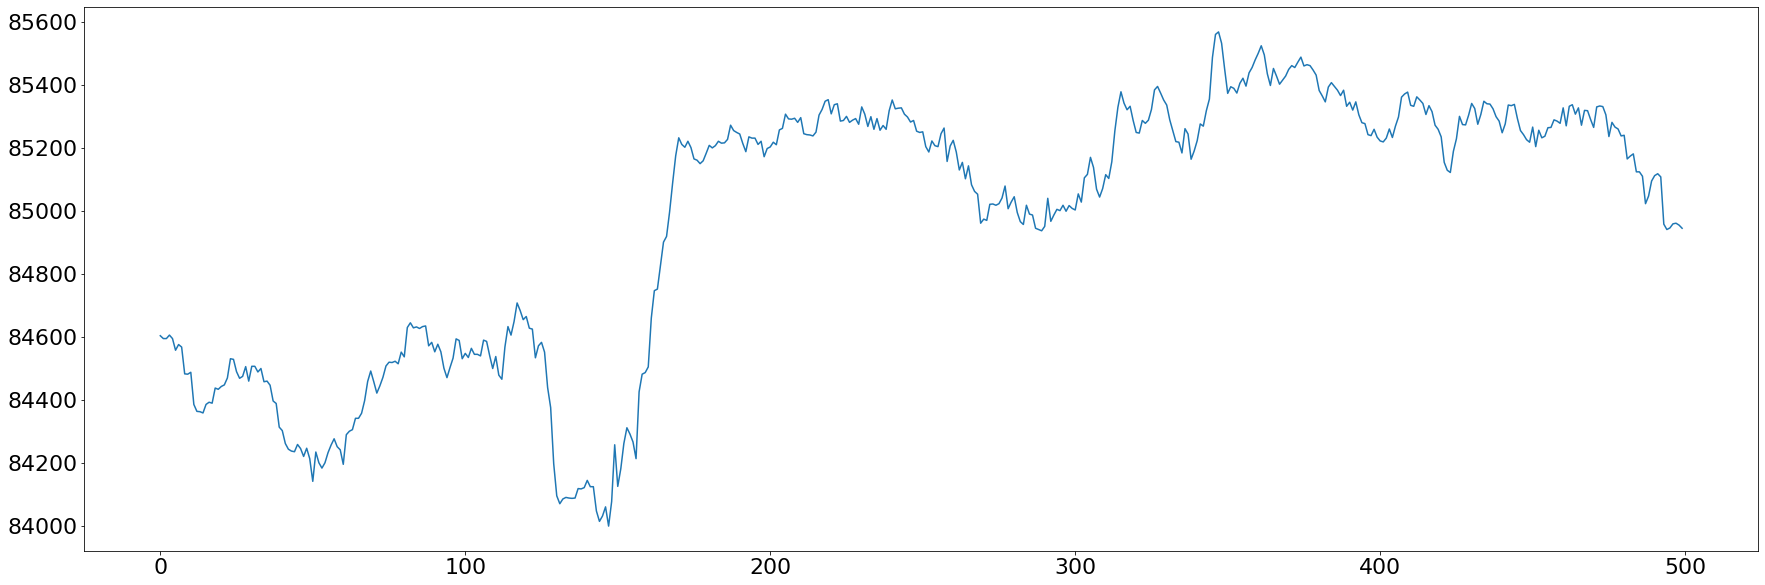

In [15]:
fig = plt.figure(facecolor=(1, 1, 1))
plt.figure(figsize=(30, 10))
x = portfolio.iloc[-500:]['time']
y = portfolio.iloc[-500:]['total']
values = range(len(x))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.plot(values,y)
plt.savefig('../web/assets/portfolioStandings.png')
plt.show()

In [17]:
portfolio.dropna().to_csv("../web/assets/portfolio.csv")

In [20]:
plt.plot(np.exp(df['returns'].tail(5000).dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].tail(5000).dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

KeyError: 'returns'

In [ ]:
# # final value for each column

# print("Returns over time period specified within api call: ")
# marketR = np.exp(df['returns'].dropna()).cumprod().iloc[-1]-1
# stratR = np.exp(df['strat_return'].dropna()).cumprod().iloc[-1]-1
# percentageM = "{:.0%}".format(marketR)
# percentageS = "{:.0%}".format(stratR)
# print('Market: ', percentageM, 'Strat: ', percentageS)
# final value for each column
print("Returns over time period specified within api call: ")
print(np.exp(df['returns'].tail(5000).dropna()).cumprod().iloc[-1] -1)
print(np.exp(df['strat_return'].tail(5000).dropna()).cumprod().iloc[-1] -1)

In [ ]:
portfolio.to_csv("../web/assets/portfolio")

In [ ]:

plt.rcParams["figure.figsize"] = (15,5)

x = portfolio['startTime']
y = portfolio['total']
values = range(len(x))
plt.plot(values,y)


# Show the plot
plt.show()

In [ ]:
# df = add_all_ta_features(
#     df, open="open", high="high", low="low", close="close", volume="volume")
# df